# Summary

Test new `get_databunch` functionality to allow for supervised task. Also test loading encoder weights.

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
from fastai2.vision.all import show_image, show_images
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
                            precision_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder, DatasetFolder

from htools import *
from img_wang.data import load_img, get_databunch, ds_subset
from img_wang.models import Encoder, SingleInputBinaryModel, \
    TorchvisionEncoder
from img_wang.torch_utils import gpu_setup, top_mistakes
from incendio.callbacks import MetricHistory, ModelCheckpoint, EarlyStopper
from incendio.core import Trainer
from incendio.metrics import mean_soft_prediction, std_soft_prediction, \
    percent_positive

In [75]:
cd_root()
gpu_setup()

Current directory: /Users/hmamin/img_wang
Setting seeds for reproducible training.


/Users/hmamin/img_wang/lib/img_wang/torch_utils.py:84: UserWarning: Cuda not available.
  if not torch.cuda.is_available(): warnings.warn('Cuda not available.')
/Users/hmamin/img_wang/lib/img_wang/torch_utils.py:85: UserWarning: Incendio device is not cuda.
  if DEVICE.type != 'cuda': warnings.warn('Incendio device is not cuda.')


## Load Supervised DS

In [202]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/', mode='supervised',
                                   bs=16, max_train_len=32, max_val_len=32)

In [203]:
dst.class_to_idx == dsv.class_to_idx

True

In [204]:
lmap(len, dst, dsv, dlt, dlv)

[32, 32, 2, 2]

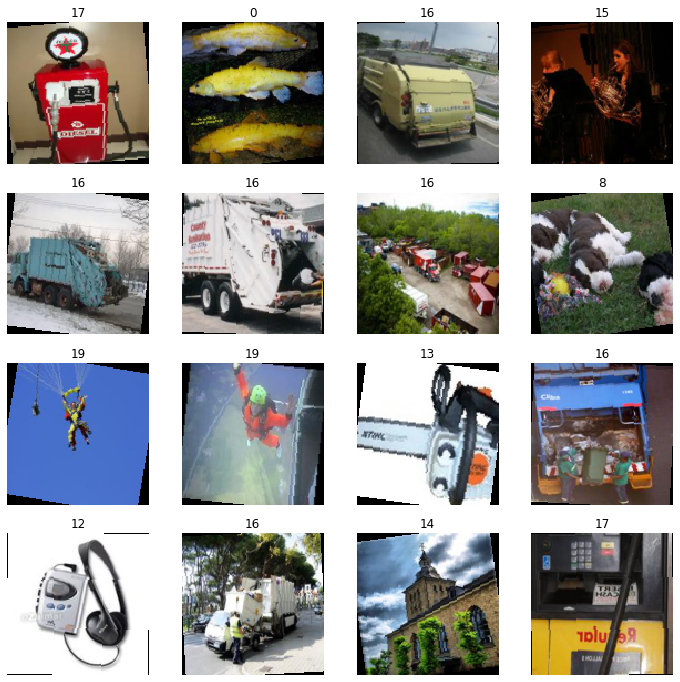

In [211]:
xb, yb = next(iter(dlt))
show_images(xb, nrows=4, titles=yb.tolist())

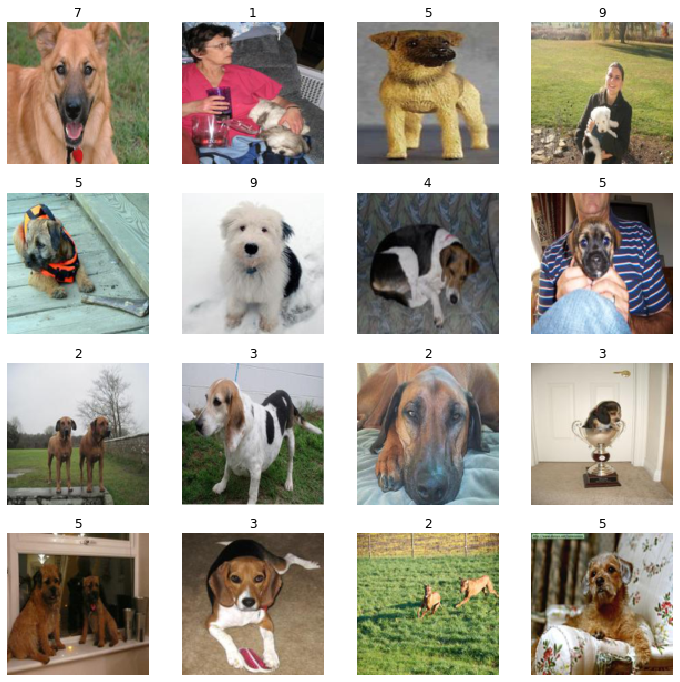

In [210]:
xb, yb = next(iter(dlv))
show_images(xb, nrows=4, titles=yb.tolist())

In [8]:
net = SingleInputBinaryModel(
    TorchvisionEncoder('resnext101_32x8d', pretrained=False),
    n_out=len(dst.classes)
)

In [9]:
yh = net.predict(xb)
F.cross_entropy(yh, yb)

tensor(2.9957)

In [10]:
nn.Softmax(1)(yh)

tensor([[0.0504, 0.0498, 0.0498, 0.0504, 0.0511, 0.0491, 0.0501, 0.0499, 0.0494,
         0.0497, 0.0494, 0.0507, 0.0493, 0.0503, 0.0504, 0.0510, 0.0496, 0.0500,
         0.0503, 0.0495],
        [0.0503, 0.0499, 0.0499, 0.0504, 0.0509, 0.0490, 0.0500, 0.0499, 0.0494,
         0.0496, 0.0495, 0.0507, 0.0493, 0.0503, 0.0504, 0.0511, 0.0497, 0.0500,
         0.0503, 0.0494],
        [0.0503, 0.0499, 0.0499, 0.0505, 0.0510, 0.0489, 0.0501, 0.0499, 0.0494,
         0.0496, 0.0494, 0.0508, 0.0492, 0.0502, 0.0504, 0.0511, 0.0496, 0.0500,
         0.0503, 0.0494],
        [0.0506, 0.0497, 0.0500, 0.0506, 0.0511, 0.0487, 0.0501, 0.0500, 0.0494,
         0.0496, 0.0494, 0.0507, 0.0491, 0.0504, 0.0505, 0.0513, 0.0496, 0.0500,
         0.0501, 0.0493],
        [0.0504, 0.0498, 0.0498, 0.0504, 0.0509, 0.0492, 0.0501, 0.0499, 0.0493,
         0.0498, 0.0495, 0.0507, 0.0492, 0.0504, 0.0504, 0.0510, 0.0497, 0.0499,
         0.0504, 0.0494],
        [0.0505, 0.0499, 0.0497, 0.0507, 0.0511, 0.0488, 0.0

In [14]:
nn.Softmax(1)(yh).detach().cpu().numpy().argmax(-1)

array([ 4, 15, 15, 15, 15, 15,  4, 15, 15])

In [16]:
yb

tensor([7, 6, 7, 0, 9, 1, 6, 1, 6])

In [17]:
accuracy_score(nn.Softmax(1)(yh).argmax(-1).detach().cpu(), yb.cpu())

0.0

In [100]:
F.cross_entropy(yh, yb, reduction='none')

tensor([2.9627, 2.9775, 2.9915, 2.9688, 2.9998, 2.9551, 3.0109, 2.9974, 2.9629])

In [77]:
torch.tensor([[0.6663],
        [0.6782],
        [0.6695],
        [0.6969],
        [0.6578],
        [0.6901],
        [0.6712],
        [0.6898],
        [0.6728]]).mean()

tensor(0.6770)

In [100]:
def load_encoder(net, enc_version):
    state = torch.load(f'data/models/{enc_version}/trainer.pkl')
    enc_state = {k: v for k, v in state['model'].items()
                 if k.split('.')[1] == '0'}
    net.load_state_dict(enc_state, strict=False)
    return net

In [101]:
net.groups[0].weight_stats()[:10]

[(0.0, 0.025),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.088),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.029),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.089)]

In [102]:
[p.mean() for p in net.groups[2].parameters()]

[tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(1.2280e-05, grad_fn=<MeanBackward0>),
 tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(-0.0006, grad_fn=<MeanBackward0>)]

In [103]:
net = load_encoder(net, 'v7')

In [104]:
net.groups[0].weight_stats()[:10]

[(-0.001, 0.04),
 (0.991, 0.065),
 (0.023, 0.072),
 (-0.0, 0.094),
 (1.0, 0.035),
 (-0.003, 0.035),
 (-0.001, 0.042),
 (0.999, 0.035),
 (-0.003, 0.029),
 (-0.001, 0.092)]

In [105]:
[p.mean() for p in net.groups[2].parameters()]

[tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(1.2280e-05, grad_fn=<MeanBackward0>),
 tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(-0.0006, grad_fn=<MeanBackward0>)]

## Scratch

In [95]:
# new_state = net.groups[0].state_dict()
new_state = net.state_dict()

In [76]:
state = torch.load('data/models/v7/trainer.pkl')

In [ ]:
# enc_state = {k.replace('groups.0.', ''): v 
#              for k, v in state['model'].items() if k.split('.')[1] == '0'}
enc_state = {k: v for k, v in state['model'].items() if k.split('.')[1] == '0'}
# enc_state = {k: v for k, v in state['model'].items() 
#              if k.split('.')[1] == '0' and 'bn' not in k}

In [90]:
len(state['model']), len(enc_state), len(new_state)

(636, 624, 624)

In [91]:
enc_state.keys() == new_state.keys()

False

In [96]:
len(enc_state.keys() - new_state.keys())

0

In [97]:
len(new_state.keys() - enc_state.keys())

12

In [81]:
eprint(list(zip(enc_state, new_state))[:10])

 0: ('model.0.weight', 'model.0.weight')
 1: ('model.1.weight', 'model.1.weight')
 2: ('model.1.bias', 'model.1.bias')
 3: ('model.1.running_mean', 'model.1.running_mean')
 4: ('model.1.running_var', 'model.1.running_var')
 5: ('model.1.num_batches_tracked', 'model.1.num_batches_tracked')
 6: ('model.4.0.conv1.weight', 'model.4.0.conv1.weight')
 7: ('model.4.0.bn1.weight', 'model.4.0.bn1.weight')
 8: ('model.4.0.bn1.bias', 'model.4.0.bn1.bias')
 9: ('model.4.0.bn1.running_mean', 'model.4.0.bn1.running_mean')


In [82]:
net.groups[0].weight_stats()[:15]

[(0.0, 0.026),
 (1.0, 0.0),
 (0.0, 0.0),
 (-0.0, 0.089),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.029),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.001, 0.089),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.087),
 (1.0, 0.0),
 (0.0, 0.0)]

In [84]:
[p.mean() for p in net.groups[2].parameters()]

[tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(5.0396e-06, grad_fn=<MeanBackward0>),
 tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(0.0015, grad_fn=<MeanBackward0>)]

In [85]:
net.groups[0].load_state_dict(enc_state)

<All keys matched successfully>

In [87]:
net.groups[0].weight_stats()[:10]

[(-0.001, 0.04),
 (0.991, 0.065),
 (0.023, 0.072),
 (-0.0, 0.094),
 (1.0, 0.035),
 (-0.003, 0.035),
 (-0.001, 0.042),
 (0.999, 0.035),
 (-0.003, 0.029),
 (-0.001, 0.092)]

In [88]:
[p.mean() for p in net.groups[2].parameters()]

[tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(5.0396e-06, grad_fn=<MeanBackward0>),
 tensor(1., grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>),
 tensor(0.0015, grad_fn=<MeanBackward0>)]

In [134]:
t = Trainer(net, dst, dsv, dlt, dlv, F.binary_cross_entropy_with_logits,
            mode='binary', out_dir='data/models/v0', last_act=torch.sigmoid,
            callbacks=[MetricHistory(None, None),
                       CometCallbackWithGrads('img_wang'),
                       EarlyStopper('loss', 'min', patience=5)],
            metrics=[mean_soft_prediction, std_soft_prediction, percent_positive, 
                     accuracy_score, f1_score, recall_score, precision_score,
                     roc_auc_score])

In [135]:
t.load('trainer.pkl')

2020-09-16 05:47:02,828 [INFO]: Loading weights from data/models/v0/trainer.pkl.
